In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)
n_samples = 2000

# Urban Features
population_density = np.random.randint(1000, 20000, n_samples)
green_cover_percent = np.random.uniform(5, 45, n_samples)
traffic_volume = np.random.randint(100, 5000, n_samples)
urban_zone = np.random.choice(['Residential', 'Commercial', 'Industrial'], n_samples)

# Environmental
temperature_c = np.random.uniform(10, 45, n_samples)
humidity_percent = np.random.uniform(20, 90, n_samples)
wind_speed = np.random.uniform(0.5, 8, n_samples)
rainfall_mm = np.random.uniform(0, 30, n_samples)

# Targets (Layer 1)
energy_consumption_kwh = (
    population_density * 0.8 +
    traffic_volume * 0.3 +
    temperature_c * 15 -
    green_cover_percent * 10 +
    np.random.normal(0, 500, n_samples)
)

aqi = (
    traffic_volume * 0.05 +
    population_density * 0.02 -
    green_cover_percent * 1.5 -
    wind_speed * 10 +
    np.random.normal(0, 20, n_samples)
)

pollution_level = pd.cut(aqi, bins=[0, 100, 200, np.inf], labels=['Low', 'Medium', 'High'])

sustainability_index = np.where(
    (green_cover_percent > 30) & (aqi < 100) & (energy_consumption_kwh < 15000),
    'Good',
    np.where(aqi < 180, 'Moderate', 'Poor')
)

df = pd.DataFrame({
    'population_density': population_density,
    'urban_zone': urban_zone,
    'green_cover_percent': green_cover_percent,
    'traffic_volume': traffic_volume,
    'temperature_c': temperature_c,
    'humidity_percent': humidity_percent,
    'wind_speed': wind_speed,
    'rainfall_mm': rainfall_mm,
    'energy_consumption_kwh': energy_consumption_kwh,
    'aqi': aqi,
    'pollution_level': pollution_level,
    'sustainability_index': sustainability_index
})

df.head()


,population_density,urban_zone,green_cover_percent,traffic_volume,temperature_c,humidity_percent,wind_speed,rainfall_mm,energy_consumption_kwh,aqi,pollution_level,sustainability_index
0,16795,Commercial,24.973353,2144,29.525771,33.753786,5.046452,4.112038,14335.107475,313.342417,High,Poor
1,1860,Industrial,15.640771,3652,20.650766,37.600111,4.683236,5.196109,2031.165932,186.538668,Medium,Poor
2,6390,Commercial,10.969511,2441,13.026013,32.150050,5.385021,1.632304,4740.614116,167.643551,Medium,Moderate
3,12964,Commercial,10.087991,3314,10.049992,87.048471,1.655568,19.699709,12150.651212,407.666500,High,Poor
4,12284,Industrial,39.586416,349,25.735417,79.823222,5.349013,25.110234,9969.713663,153.429468,Medium,Moderate


In [8]:
df['pollution_level'] = df['pollution_level'].astype(str)
df['sustainability_index'] = df['sustainability_index'].astype(str)


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['energy_norm','aqi_norm']] = scaler.fit_transform(df[['energy_consumption_kwh','aqi']])

df['energy_score'] = 1 - df['energy_norm']
df['aqi_score'] = 1 - df['aqi_norm']

pollution_map = {'Low':1, 'Medium':0.6, 'High':0.2}
sustainability_map = {'Good':1, 'Moderate':0.6, 'Poor':0.2}

df['pollution_score'] = df['pollution_level'].map(pollution_map)
df['sustainability_score'] = df['sustainability_index'].map(sustainability_map)

df['final_score'] = (
    0.30*df['energy_score'] +
    0.30*df['aqi_score'] +
    0.20*df['pollution_score'] +
    0.20*df['sustainability_score']
)

def rate(x):
    if x >= 0.80: return "Excellent"
    elif x >= 0.65: return "Good"
    elif x >= 0.50: return "Average"
    elif x >= 0.35: return "Poor"
    else: return "Very Poor"

df['urban_sustainability_rating'] = df['final_score'].apply(rate)

df[['energy_consumption_kwh','aqi','pollution_level',
    'sustainability_index','urban_sustainability_rating']].head()


,energy_consumption_kwh,aqi,pollution_level,sustainability_index,urban_sustainability_rating
0,14335.107475,313.342417,High,Poor,Very Poor
1,2031.165932,186.538668,Medium,Poor,Average
2,4740.614116,167.643551,Medium,Moderate,Good
3,12150.651212,407.666500,High,Poor,Very Poor
4,9969.713663,153.429468,Medium,Moderate,Average


In [14]:
pollution_encode = {'Low':0, 'Medium':1, 'High':2}
sustainability_encode = {'Poor':0, 'Moderate':1, 'Good':2}

df['pollution_encoded'] = df['pollution_level'].map(pollution_encode)
df['sustainability_encoded'] = df['sustainability_index'].map(sustainability_encode)

X = df[['energy_consumption_kwh','aqi','pollution_encoded','sustainability_encoded']]
y = df['urban_sustainability_rating']


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

     Average       1.00      0.98      0.99        52
   Excellent       1.00      1.00      1.00        36
        Good       0.98      1.00      0.99        46
        Poor       0.96      1.00      0.98       102
   Very Poor       1.00      0.98      0.99       164

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [20]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   population_density           2000 non-null   int32  
 1   urban_zone                   2000 non-null   object 
 2   green_cover_percent          2000 non-null   float64
 3   traffic_volume               2000 non-null   int32  
 4   temperature_c                2000 non-null   float64
 5   humidity_percent             2000 non-null   float64
 6   wind_speed                   2000 non-null   float64
 7   rainfall_mm                  2000 non-null   float64
 8   energy_consumption_kwh       2000 non-null   float64
 9   aqi                          2000 non-null   float64
 10  pollution_level              2000 non-null   object 
 11  sustainability_index         2000 non-null   object 
 12  energy_norm                  2000 non-null   float64
 13  aqi_norm          

In [22]:
df.dtypes

population_density               int32
urban_zone                      object
green_cover_percent            float64
traffic_volume                   int32
temperature_c                  float64
humidity_percent               float64
wind_speed                     float64
rainfall_mm                    float64
energy_consumption_kwh         float64
aqi                            float64
pollution_level                 object
sustainability_index            object
energy_norm                    float64
aqi_norm                       float64
energy_score                   float64
aqi_score                      float64
pollution_score                float64
sustainability_score           float64
final_score                    float64
urban_sustainability_rating     object
pollution_encoded              float64
sustainability_encoded           int64
dtype: object

In [24]:
df.describe()


,population_density,green_cover_percent,traffic_volume,temperature_c,humidity_percent,wind_speed,rainfall_mm,energy_consumption_kwh,aqi,energy_norm,aqi_norm,energy_score,aqi_score,pollution_score,sustainability_score,final_score,pollution_encoded,sustainability_encoded
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,1952.000000,2000.000000,1952.000000,1952.000000,2000.000000
mean,10324.428500,25.407411,2545.182000,26.969722,55.015204,4.260316,14.952148,9180.449149,252.920362,0.502533,0.489609,0.497467,0.510391,0.386475,0.353400,0.442148,1.533811,0.383500
std,5416.859991,11.533180,1429.330974,9.980182,19.903648,2.183343,8.809540,4405.125043,135.287004,0.246186,0.191777,0.246186,0.191777,0.278499,0.243183,0.208547,0.696248,0.607958
min,1009.000000,5.007536,101.000000,10.008435,20.003698,0.501183,0.040009,188.400342,-92.468292,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.090586,0.000000,0.000000
25%,5759.250000,15.553288,1267.750000,18.355267,37.968119,2.365507,7.152927,5465.645084,152.208834,0.294926,0.346844,0.292755,0.365037,0.200000,0.200000,0.280366,1.000000,0.000000
50%,10130.000000,25.836827,2566.500000,26.576144,54.985508,4.217560,14.708565,9174.160886,251.322157,0.502181,0.487344,0.497819,0.512656,0.200000,0.200000,0.380475,2.000000,0.000000
75%,14920.000000,35.350981,3781.250000,35.220786,71.978398,6.182808,22.931983,12843.460243,355.458603,0.707245,0.634963,0.705074,0.653156,0.600000,0.600000,0.621610,2.000000,1.000000
max,19988.000000,44.988552,4999.000000,44.972255,89.965363,7.997549,29.965345,18081.852915,612.969296,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.931988,2.000000,2.000000


In [26]:
df.isnull().sum()

population_density              0
urban_zone                      0
green_cover_percent             0
traffic_volume                  0
temperature_c                   0
humidity_percent                0
wind_speed                      0
rainfall_mm                     0
energy_consumption_kwh          0
aqi                             0
pollution_level                 0
sustainability_index            0
energy_norm                     0
aqi_norm                        0
energy_score                    0
aqi_score                       0
pollution_score                48
sustainability_score            0
final_score                    48
urban_sustainability_rating     0
pollution_encoded              48
sustainability_encoded          0
dtype: int64

In [28]:
df.fillna(df.mean(numeric_only=True), inplace=True)


In [30]:
df.isnull().sum()


population_density             0
urban_zone                     0
green_cover_percent            0
traffic_volume                 0
temperature_c                  0
humidity_percent               0
wind_speed                     0
rainfall_mm                    0
energy_consumption_kwh         0
aqi                            0
pollution_level                0
sustainability_index           0
energy_norm                    0
aqi_norm                       0
energy_score                   0
aqi_score                      0
pollution_score                0
sustainability_score           0
final_score                    0
urban_sustainability_rating    0
pollution_encoded              0
sustainability_encoded         0
dtype: int64

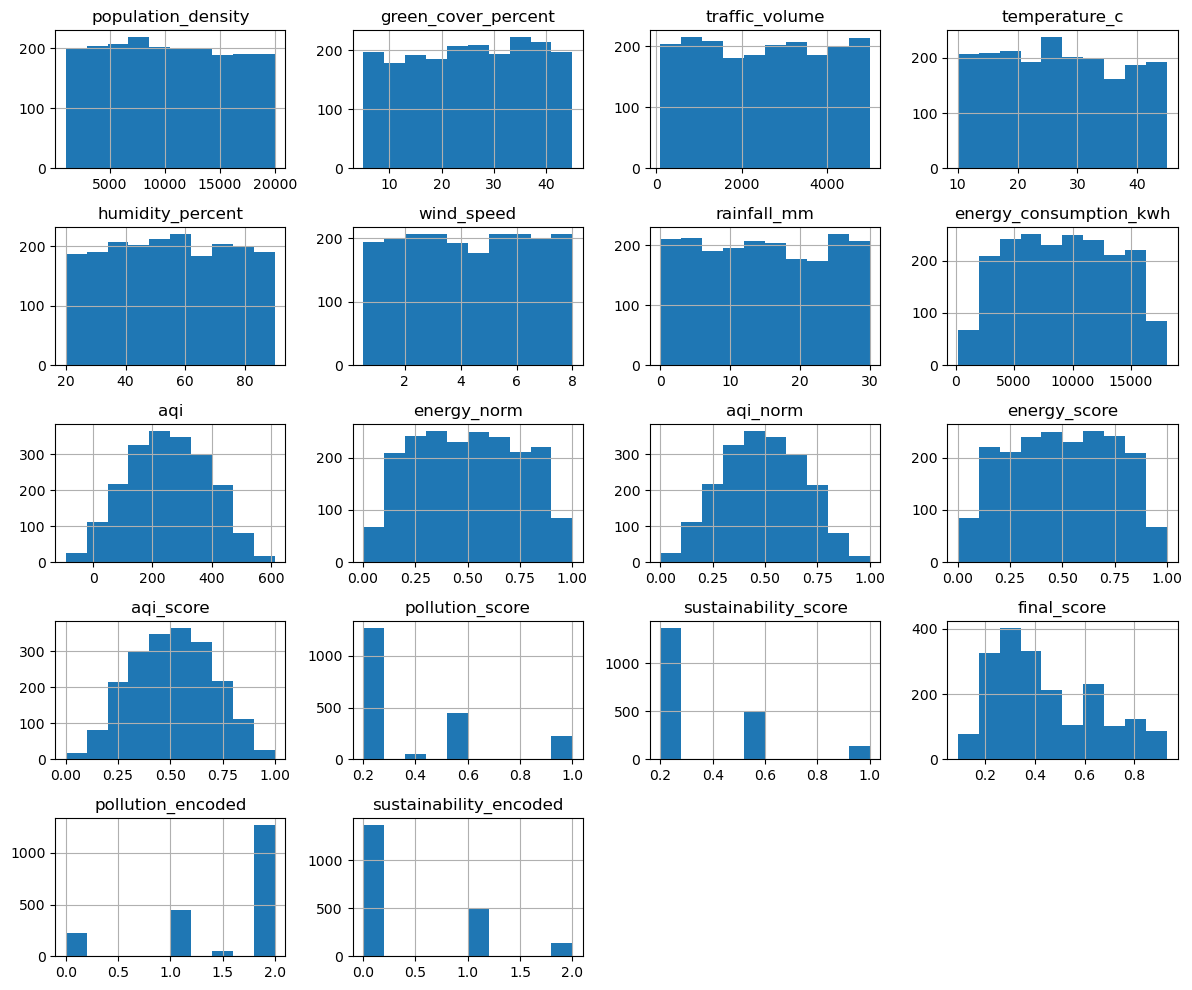

In [32]:
import matplotlib.pyplot as plt

df.hist(figsize=(12,10))
plt.tight_layout()
plt.show()


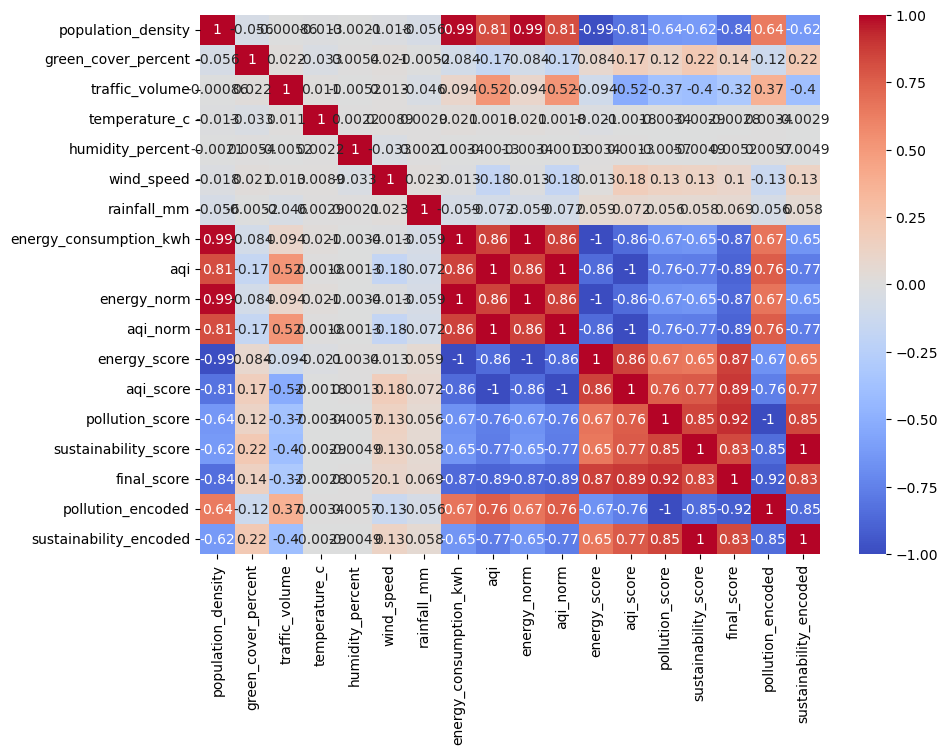

In [34]:
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()


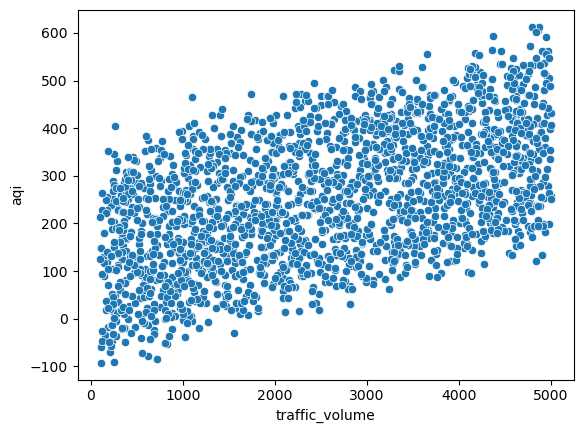

In [36]:
sns.scatterplot(x="traffic_volume", y="aqi", data=df)
plt.show()


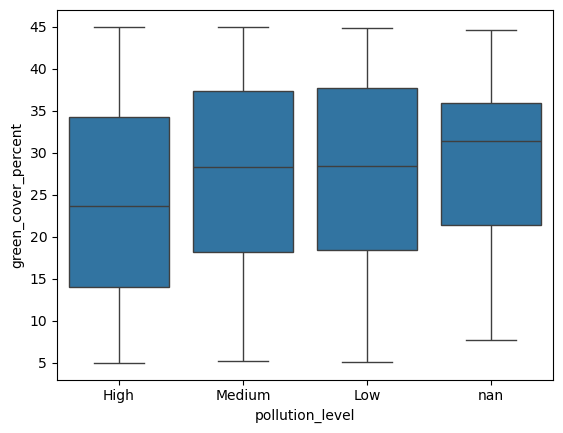

In [38]:
sns.boxplot(x="pollution_level", y="green_cover_percent", data=df)
plt.show()


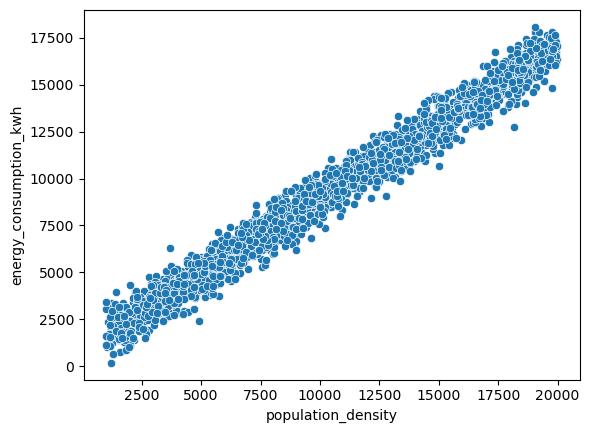

In [40]:
sns.scatterplot(x="population_density", y="energy_consumption_kwh", data=df)
plt.show()


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=300, max_depth=12)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))


Accuracy: 0.9875


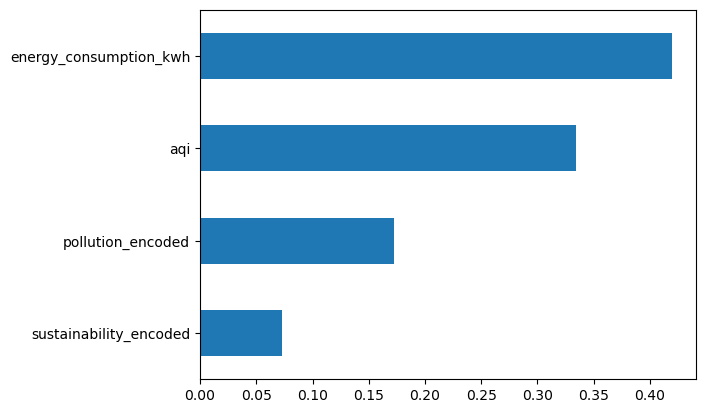

In [44]:
import pandas as pd

importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values().plot(kind='barh')
plt.show()


In [48]:
import pickle

pickle.dump(model, open("model.pkl", "wb"))
print("model.pkl succesfully launched")


model.pkl succesfully launched
